In [3]:
# Loading Libraries

import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Loading Data
df = pd.read_csv('hatespeech.csv')
df.head(10)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [26]:
# Display concise summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [28]:
# drop unnecessary columns

df = (df
    .drop(columns=["count", "hate_speech_count", "offensive_language_count", "neither_count"])
)
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [30]:
# Checking for duplicate values
df.drop_duplicates(inplace=True)


In [31]:
# looking at distribution of class labels

df["class"].value_counts(dropna=False, normalize=True).sort_index()

0    0.057701
1    0.774321
2    0.167978
Name: class, dtype: float64

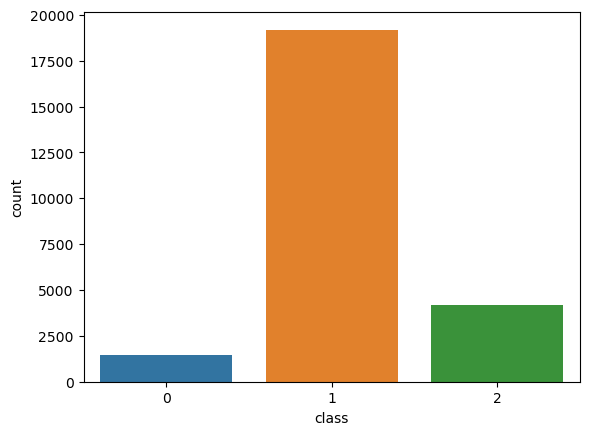

In [6]:
# visual of distribution of class labels

''' 0 : Hate speech
    1 : offensive_language
    2 : Neither hate nor offensive 
'''
sns.countplot(x=df['class'])
plt.show()

In [7]:
# Extract the 'tweet' column from the DataFrame
tweets = df['tweet']

# Import the stopwords from the NLTK library
from nltk.corpus import stopwords

# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean a tweet
def clean_tweet(tweet):
    # Remove RT (Retweet)
    tweet = re.sub(r'\brt\b', '', tweet, flags=re.IGNORECASE)
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Remove mentions (e.g., @username)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove special characters and numbers, keep only letters
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove stopwords
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    
    return tweet

# Call the cleaning function on the 'tweets' column
cleaned_tweets = tweets.apply(clean_tweet)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joellerudolph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Setting class labels
labels = list(df['class'])

In [9]:
# Import the train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# 'cleaned_tweets' is the feature (X), and 'labels' is the target variable (y)
x_train, x_test, y_train, y_test = train_test_split(cleaned_tweets, labels, test_size=0.2, random_state=42)

In [10]:
# TF-IDF Vectorization for traditional models
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [11]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
    "Support Vector Machine": SVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

In [14]:
# Function for confusion matrix for each model
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


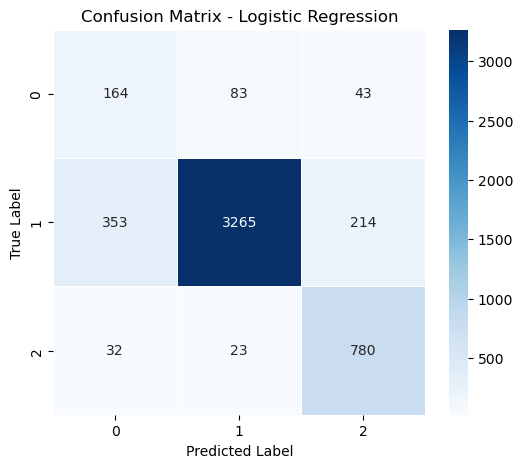

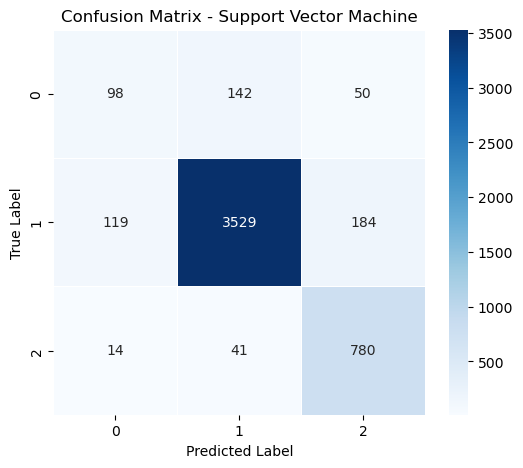

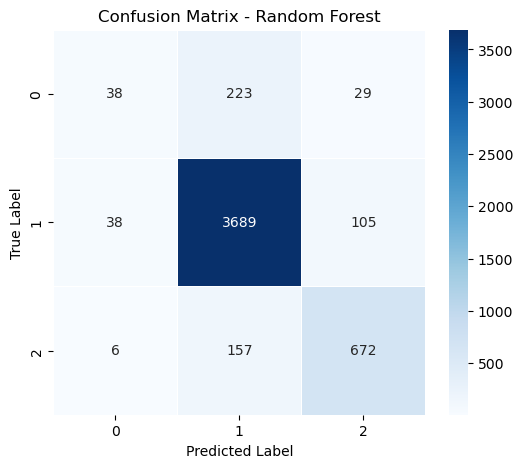

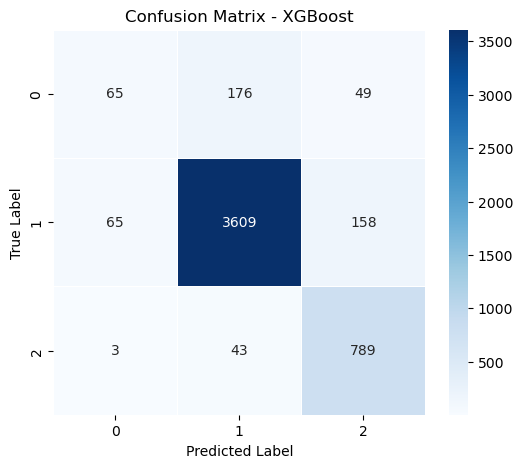

In [13]:
# Train and evaluate traditional models
results = {}
for name, model in models.items():
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1 Score": f1_score(y_test, y_pred, average="macro")
    }
    # Plot each traditional model's confusion matrix
    plot_confusion_matrix(y_test, y_pred, name)


In [15]:
# Tokenization & Padding for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

In [16]:
# Define LSTM model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

In [17]:
# Compiling LSTM model before training
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Ran into error with data type, so converting data type
X_train_pad = np.array(X_train_pad, dtype=np.float32)
X_test_pad = np.array(X_test_pad, dtype=np.float32)

y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

In [19]:
# Train LSTM Model
lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=8, validation_data=(X_test_pad, y_test))


Epoch 1/5
2479/2479 [==============================] - 74s 30ms/step - loss: -3.4115 - accuracy: 0.7745 - val_loss: -5.8797 - val_accuracy: 0.7730
Epoch 2/5
2479/2479 [==============================] - 73s 30ms/step - loss: -8.3531 - accuracy: 0.7746 - val_loss: -10.7630 - val_accuracy: 0.7730
Epoch 3/5
2479/2479 [==============================] - 73s 29ms/step - loss: -13.2534 - accuracy: 0.7746 - val_loss: -15.6498 - val_accuracy: 0.7730
Epoch 4/5
2479/2479 [==============================] - 73s 29ms/step - loss: -18.1391 - accuracy: 0.7746 - val_loss: -20.4952 - val_accuracy: 0.7730
Epoch 5/5
2479/2479 [==============================] - 72s 29ms/step - loss: -22.9735 - accuracy: 0.7746 - val_loss: -25.3208 - val_accuracy: 0.7730


In [20]:
# Evaluate LSTM
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
results["LSTM"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lstm),
    "Precision": precision_score(y_test, y_pred_lstm, average="macro"),
    "Recall": recall_score(y_test, y_pred_lstm, average="macro"),
    "F1 Score": f1_score(y_test, y_pred_lstm, average="macro")
}

155/155 [==============================] - 2s 13ms/step


/Users/joellerudolph/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Print results for all models
for model, scores in results.items():
    print(f"\n{model} Performance:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.5f}")


Logistic Regression Performance:
Accuracy: 0.84910
Precision: 0.67315
Recall: 0.78389
F1 Score: 0.71028

Support Vector Machine Performance:
Accuracy: 0.88905
Precision: 0.71472
Recall: 0.73100
F1 Score: 0.71849

Random Forest Performance:
Accuracy: 0.88743
Precision: 0.73459
Recall: 0.63284
F1 Score: 0.65237

XGBoost Performance:
Accuracy: 0.90034
Precision: 0.74123
Recall: 0.70362
F1 Score: 0.70382

LSTM Performance:
Accuracy: 0.77305
Precision: 0.25768
Recall: 0.33333
F1 Score: 0.29067


## Visualizations

In [22]:
# Results dictionary 
results = {
    "Logistic Regression": {"Accuracy": 0.84910, "Precision": 0.67315, "Recall": 0.78389, "F1 Score": 0.71028},
    "Support Vector Machine": {"Accuracy": 0.88905, "Precision": 0.71472, "Recall": 0.73100, "F1 Score": 0.71849},
    "Random Forest": {"Accuracy": 0.88743, "Precision": 0.73459, "Recall": 0.63284, "F1 Score": 0.65237},
    "XGBoost": {"Accuracy": 0.90034, "Precision": 0.74123, "Recall": 0.70362, "F1 Score": 0.70382},
    "LSTM": {"Accuracy": 0.77305, "Precision": 0.25768, "Recall": 0.33333, "F1 Score": 0.29067}
}


In [23]:
# Extract metrics for visualization
models = list(results.keys())
accuracy = [results[m]["Accuracy"] for m in models]
precision = [results[m]["Precision"] for m in models]
recall = [results[m]["Recall"] for m in models]
f1_score = [results[m]["F1 Score"] for m in models]


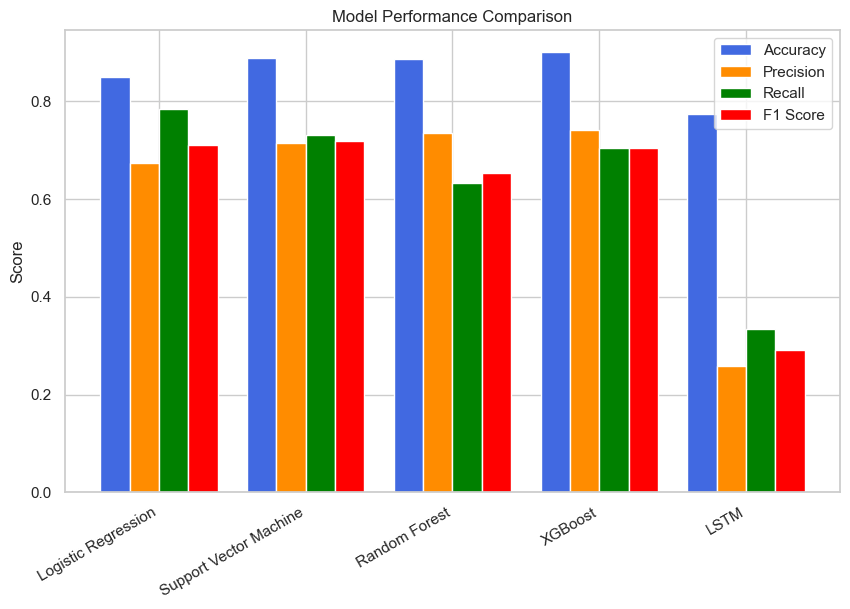

In [24]:
# Bar Graph of Model Performance

# Set seaborn style
sns.set(style="whitegrid")

# Create a bar chart for model performance
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))

ax.bar(x - 0.3, accuracy, width=0.2, label="Accuracy", color="royalblue")
ax.bar(x - 0.1, precision, width=0.2, label="Precision", color="darkorange")
ax.bar(x + 0.1, recall, width=0.2, label="Recall", color="green")
ax.bar(x + 0.3, f1_score, width=0.2, label="F1 Score", color="red")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.legend()
plt.show()

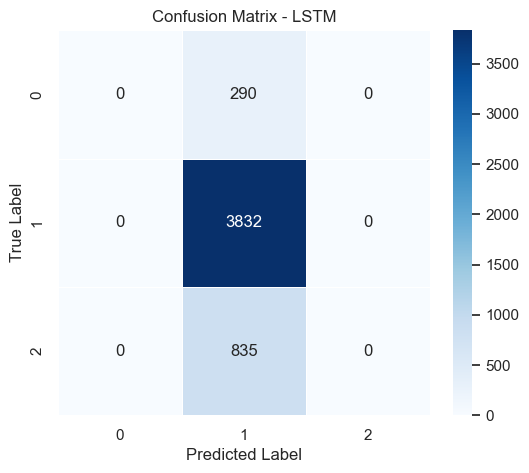

In [64]:
# Confusion matrix for LSTM model
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM")